# IEEE Transaction on Network and Service Management Reproducibles


## About 

This notebook evaluates several different online learning algorithms on the [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) ([link](https://ieeexplore.ieee.org/abstract/document/7348942) to paper). The UNSW-NB15 dataset has nine types of attacks, namely, Fuzzers, Analysis, Backdoors, DoS, Exploits, Generic, Reconnaissance, Shellcode and Worms. The Argus, Bro-IDS tools are used and twelve algorithms are developed to generate totally 49 features with the class label. This notebook looks at the problem of detecting binary attacks (i.e., we do not consider classifying a specific attack). The original features in the UNSW-NB15 dataset were reduced based on some preliminary work and identification of features that could not easily be processed by the classifiers and exploratory data analysis. 

[Scikit Multiflow](https://scikit-multiflow.github.io/) is required to run the code and will be installed when the notebook is run. Furthermore, the data must be downloaded from UNSW-NB15's website and the current notebook is accessing the data through a Google Drive. 

**To Do**
- Write code to produce the joint mutual information scores tthen generatet a plot that is similar to the plot of correlations between the features. 
- Plot the confusion matrix for the multiclassification tasks. We do not need a confusion matrix for the binary classification tasks or the prequential evaluation tasks. 


## Citing this work 
* G. Ditzler, S. Gupta, P. Satam, and S. Hariri, "Beyond Signature-Based Intrusion Detection with Online Learning," in preparation for *IEEE Transactions on Network and Service Management*, 2021. 

# Imports and Installs

We need to install the Scikit Multiflow library because it is not installed by default on Google Colab; however, the remainder of the libraries are installed on Google Colab. Note, I am connecting to my Google Drive to access the data rather than manually mounting my Google Drive. You can place the [UNSW-NB15 Dataset](https://www.unsw.adfa.edu.au/unsw-canberra-cyber/cybersecurity/ADFA-NB15-Datasets/) and place it in a folder named ```Data/UNSWNB15/``` on your Google Drive. Once the code mounts the drive, the rest of the program should know where the data are located. 

In [ ]:
!pip install -U scikit-multiflow

Requirement already up-to-date: scikit-multiflow in /usr/local/lib/python3.6/dist-packages (0.5.3)


In [ ]:
!pip install install git+git://github.com/jundongl/scikit-feature

  Cloning git://github.com/jundongl/scikit-feature to /tmp/pip-req-build-y2hd1ac4
  Running command git clone -q git://github.com/jundongl/scikit-feature /tmp/pip-req-build-y2hd1ac4
  Created wheel for skfeature: filename=skfeature-1.0.0-cp36-none-any.whl size=61495 sha256=04b45d22de92e3283bb18fa390ef5f1686ff27643e53fe89cb6d8b2604f11d13
  Stored in directory: /tmp/pip-ephem-wheel-cache-8httm7hs/wheels/74/cc/26/2646a7e5a4b03a7a0add9ca91be5b1b0a5213a29a4afb370c9
Successfully built skfeature


In [ ]:
import os 
import numpy as np 
import scipy as sp
import pandas as pd 
import pickle as pkl 
from scipy.stats import poisson

import matplotlib.pylab as plt
plt.style.use('bmh')

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from skfeature.function.information_theoretical_based import JMI, LCSI

from skmultiflow.data import DataStream
from skmultiflow.trees import HoeffdingTreeClassifier
from skmultiflow.meta import OzaBaggingClassifier 
from skmultiflow.meta import OzaBaggingADWINClassifier 
from skmultiflow.meta import LeveragingBaggingClassifier
from skmultiflow.evaluation import EvaluatePrequential, EvaluateHoldout


from google.colab import drive, files

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# number of data samples used to pre-train the model 
pretrain_size = 2000
# prequential batch sizes 
batch_size = 1000
# classification metrics to compute in prequential online learning 
metrics = ['accuracy', 'f1', 'kappa', 'running_time', 'model_size']
# location of the data in the Google Drive 
data_path = '/content/drive/My Drive/Data/UNSWNB15/'
# location of the code in Google Drive 
code_path = '/content/drive/My Drive/Colab Notebooks/Projects/TIS-IEEE-2020_OnlineCyberDetection/'
# output path for the result files and figures 
output_path = code_path+'outputs/'
# maximum numbers to sample from the stream. we will not process 1M  
max_samples = 1000000
# poisson parameter
poisson_parameter = 4.

In [ ]:
!ls /content/drive/My\ Drive/Data/UNSWNB15

NUSW-NB15_features.csv	UNSW-NB15_2.csv  UNSW-NB15_LIST_EVENTS.csv
NUSW-NB15_GT.csv	UNSW-NB15_3.csv  UNSW_NB15_testing-set.csv
UNSW-NB15_1.csv		UNSW-NB15_4.csv  UNSW_NB15_training-set.csv


In [ ]:
# generic name of the csv files that will be saved based on where we are pointing 
# to with the output path name. 
output_files = [
                'output_ht_m',
                'output_bag_m',
                'output_bagwin_m',
                'output_leverage_m'
                ]

drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'is_sm_ips_ports']


In [ ]:
def get_attack_counts(df):
  """
  Count the number of attacks per class. 
  """
  attacks = np.unique(df['attack_cat'])
  n_attacks = np.array([(df['attack_cat']==attack).values.sum() for attack in attacks])
  sorted_idx = np.argsort(n_attacks)[::-1]
  return sorted_idx, attacks, n_attacks
    
def standardize_df(df): 
  """
  Standardize a dataframe

  df = standardize_df(df)
  """
  for key in df.keys(): 
    if key != 'target': 
      df[key] = (df[key].values - df[key].values.mean())/df[key].values.std()
  return df

def standardize_df_off_tr(df_tr, df_te): 
  """
  Standardize dataframes from a training and testing frame, where the means
  and standard deviations that are calculated from the training dataset. 

  df_tr, df_te = standardize_df_off_tr(df_tr, df_te)
  """
  for key in df_tr.keys(): 
    if key != 'target': 
      # scale the testing data w/ the training means/stds
      df_te[key] = (df_te[key].values - df_tr[key].values.mean())/df_tr[key].values.std()
      # scale the training data 
      df_tr[key] = (df_tr[key].values - df_tr[key].values.mean())/df_tr[key].values.std()
  return df_tr, df_te

def calc_metrics(y, yhat):
  """
  Calculate the accuracy, f1-score and kappa statistics 

  acc, f1, kappa = calc_metrics(y, yhat)
  """
  tp = 1.*len(np.where((y == 0) & (yhat == 0))[0])
  tn = 1.*len(np.where((y == 1) & (yhat == 1))[0])
  fp = 1.*len(np.where((y == 1) & (yhat == 0))[0])
  fn = 1.*len(np.where((y == 0) & (yhat == 1))[0])
  n = tp+tn+fp+fn
  acc = (tp+tn)/(tp+tn+fp+fn)
  f1 = 2*tp/(2*tp+fp+fn)
  
  po = 1.*acc
  py, pn = ((tp+fp)/n)*((tp+fn)/n), ((fn+tn)/n)*((fp+tn)/n)
  pe = py+pn
  kappa = (po-pe)/(1-pe)
  return acc, f1, kappa 

def jaccard(a, b): 
  """
  Compute the jaccard index between two feature sets 
  """
  return 1.*len(set(a).intersection(set(b)))/len(set(a).union(set(b)))

def kuncheva(a, b, K): 
  """
  Compute the kuncheva index between two sets 
  """
  k = len(a)
  a, b = set(sort_mite[:k]), set(sort_mitr[:k])
  r = 1.*len(a.intersection(b))
  return (r*K-k**2)/(k*(K-k))

# Exploratory Data Analysis

## Generate Table of the Dataset and Its Features

In [ ]:
df_feat = pd.read_csv(data_path + 'NUSW-NB15_features.csv', sep=',')
df_tr = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv')
df_te = pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# uncomment to print
df_feat.sort_values(by='Type ')

,No.,Name,Type,Description
35,36,is_sm_ips_ports,Binary,If source (1) and destination (3)IP addresses ...
38,39,is_ftp_login,Binary,If the ftp session is accessed by user and pas...
15,16,Dload,Float,Destination bits per second
27,28,Djit,Float,Destination jitter (mSec)
26,27,Sjit,Float,Source jitter (mSec)
31,32,Dintpkt,Float,Destination interpacket arrival time (mSec)
32,33,tcprtt,Float,"TCP connection setup round-trip time, the sum ..."
33,34,synack,Float,"TCP connection setup time, the time between th..."
34,35,ackdat,Float,"TCP connection setup time, the time between th..."
14,15,Sload,Float,Source bits per second


## Generate Generic Plots for the Text [Not Data Specific]

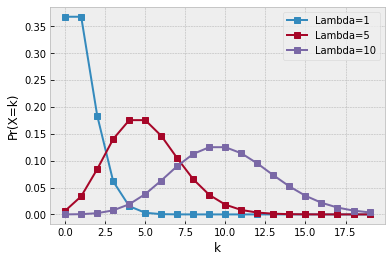

In [ ]:
p1 = poisson(1.)
p2 = poisson(5.)
p3 = poisson(10.)
x = [i for i in range(20)]

plt.figure()
plt.plot(x, p1.pmf(x), marker='s', label='Lambda=1')
plt.plot(x, p2.pmf(x), marker='s', label='Lambda=5')
plt.plot(x, p3.pmf(x), marker='s', label='Lambda=10')
plt.legend()
plt.xlabel('k')
plt.ylabel('Pr(X=k)')
plt.savefig(output_path + 'poisson.pdf')


## Plot the Class Distributions and Covariance 

In [ ]:
sorted_idx_tr, attacks_tr, n_attacks_tr = get_attack_counts(df_tr)
sorted_idx_te, attacks_te, n_attacks_te = get_attack_counts(df_te)

plt.figure()
fig, axs = plt.subplots()

index = np.arange(len(sorted_idx_tr))-1
bar_width = 0.4
opacity = 1.

rects1 = plt.barh(index, n_attacks_tr[sorted_idx_tr], bar_width, alpha=opacity, label='Training')
rects2 = plt.barh(index + bar_width, n_attacks_te[sorted_idx_tr], bar_width, alpha=opacity, label='Testing')

plt.yticks(index + .5*bar_width, tuple(attacks_tr[sorted_idx_tr]))
plt.ylabel('Attack Class')
plt.xlabel('Number of Samples')

plt.legend()

plt.savefig(code_path+'outputs/unsw-nb15_samples.pdf', bbox_inches='tight')

KeyError: ignored

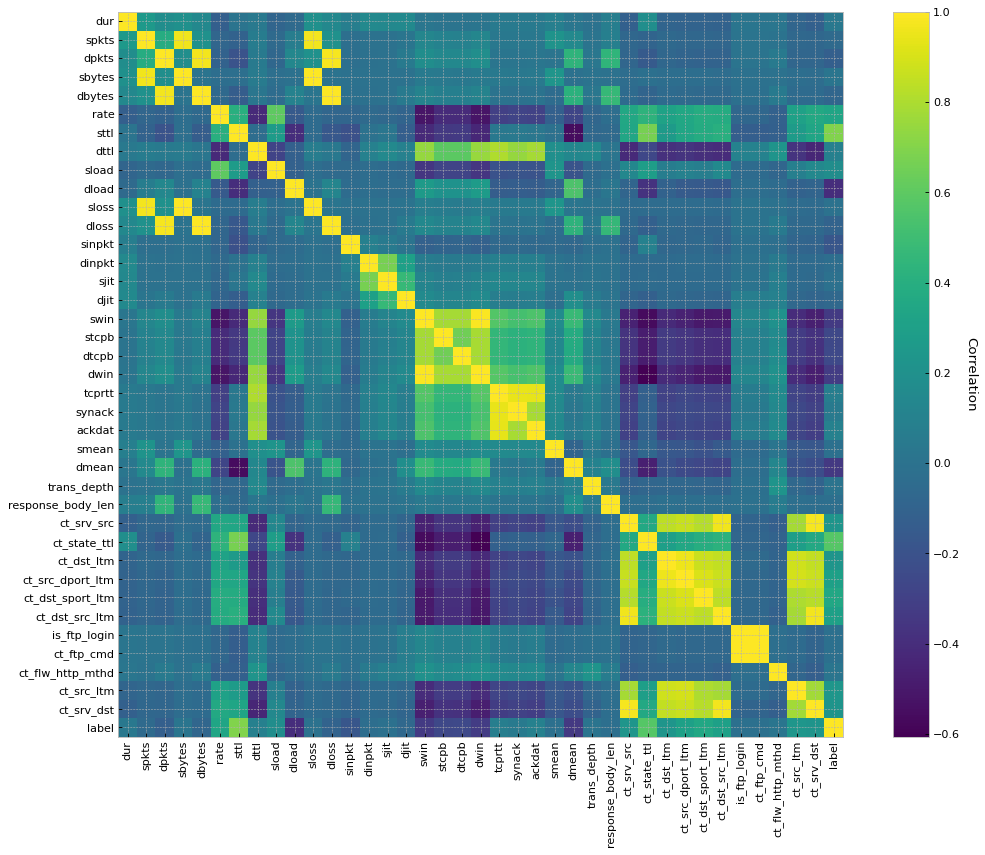

In [ ]:
df_tr_feat = df_tr.drop(drop_cols, axis = 1)
X = df_tr_feat.values


scaler = preprocessing.StandardScaler().fit(X)
Xs = scaler.transform(X)
C = np.cov(Xs.T)

fig, ax = plt.subplots(figsize=(16, 12), dpi=80)
im = ax.imshow(C)


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('Correlation', rotation=-90, va="bottom")
    
    
# We want to show all ticks...
ax.set_xticks(np.arange(len(df_tr_feat.keys())))
ax.set_yticks(np.arange(len(df_tr_feat.keys())))
# ... and label them with the respective list entries
ax.set_xticklabels(df_tr_feat.keys(), rotation=90)
ax.set_yticklabels(df_tr_feat.keys())

plt.savefig(code_path+'outputs/covariance.pdf', bbox_inches='tight')


## Plot the PCA Projections 

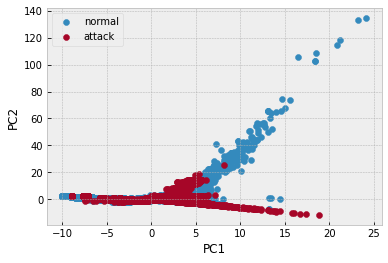

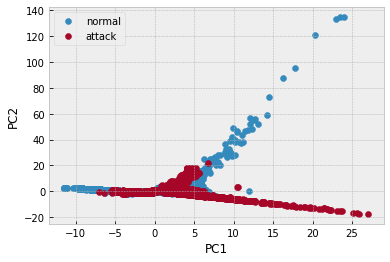

In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr, df_te = df_tr.sample(frac=1).reset_index(drop=True), df_te.sample(frac=1).reset_index(drop=True)
df_tr_drop, df_te_drop = df_tr.drop(drop_cols, axis = 1), df_te.drop(drop_cols, axis = 1)

# separate the data from the labels for the training and testing data 
Xtr, Xte = df_tr_drop.values[:,:-1], df_te_drop.values[:,:-1]
ytr, yte = df_tr_drop['label'].values, df_te_drop['label'].values

# standardize the data based on the transform found from the training data 
scaler = preprocessing.StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

# calculate the PCA projections and find projections 
pct = PCA(n_components=2).fit(Xtr)
Xtr_pca, Xte_pca = pct.transform(Xtr), pct.transform(Xte)

# plot out the PCA projections on the training and testing data 
plt.figure()
plt.scatter(Xtr_pca[ytr==1,0], Xtr_pca[ytr==1,1], label='normal')
plt.scatter(Xtr_pca[ytr==0,0], Xtr_pca[ytr==0,1], label='attack')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(output_path + 'pca_tr.pdf')

plt.figure()
plt.scatter(Xte_pca[yte==1,0], Xte_pca[yte==1,1], label='normal')
plt.scatter(Xte_pca[yte==0,0], Xte_pca[yte==0,1], label='attack')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(output_path + 'pca_te.pdf')


## Plot TSNE 

In [ ]:
df_tr_drop

,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,label
0,25.642588,42,0,2688,0,1.598903,254,0,8.186381e+02,0.000000,0,0,625.429000,0.000000,708.988875,0.00000,0,0,0,0,0.000000,0.000000,0.000000,64,0,0,0,1,2,23,1,1,23,0,0,0,23,1,1
1,0.001023,2,2,130,162,2932.551349,31,29,5.083089e+05,633431.062500,0,0,0.009000,0.006000,0.000000,0.00000,0,0,0,0,0.000000,0.000000,0.000000,65,81,0,0,2,0,1,1,1,2,0,0,0,3,3,0
2,0.516957,12,8,2162,1054,36.753541,254,252,3.067180e+04,14283.586910,3,2,46.095365,69.151859,2432.188635,99.97700,255,1288979307,2753964732,255,0.070237,0.032891,0.037346,180,132,1,109,1,1,1,1,1,1,0,0,1,1,1,1
3,0.687738,10,8,564,354,24.718716,254,252,5.909227e+03,3606.024414,2,1,75.710444,96.348570,5620.837249,136.89475,255,2700697725,4156859027,255,0.034317,0.013291,0.021026,56,44,0,0,1,1,1,1,1,1,0,0,0,1,1,1
4,0.000013,2,0,114,0,76923.077790,254,0,3.507692e+07,0.000000,0,0,0.013000,0.000000,0.000000,0.00000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,17,2,17,17,17,17,0,0,0,17,17,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175336,0.000003,2,0,200,0,333333.321500,254,0,2.666667e+08,0.000000,0,0,0.003000,0.000000,0.000000,0.00000,0,0,0,0,0.000000,0.000000,0.000000,100,0,0,0,7,2,1,1,1,7,0,0,0,1,7,1
175337,0.000008,2,0,114,0,125000.000300,254,0,5.700000e+07,0.000000,0,0,0.008000,0.000000,0.000000,0.00000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,31,2,18,17,17,31,0,0,0,17,31,1
175338,0.001053,2,2,146,178,2849.002888,31,29,5.546059e+05,676163.375000,0,0,0.008000,0.002000,0.000000,0.00000,0,0,0,0,0.000000,0.000000,0.000000,73,89,0,0,3,0,1,1,1,1,0,0,0,3,2,0
175339,0.000006,2,0,114,0,166666.660800,254,0,7.600000e+07,0.000000,0,0,0.006000,0.000000,0.000000,0.00000,0,0,0,0,0.000000,0.000000,0.000000,57,0,0,0,30,2,13,13,13,30,0,0,0,14,30,1


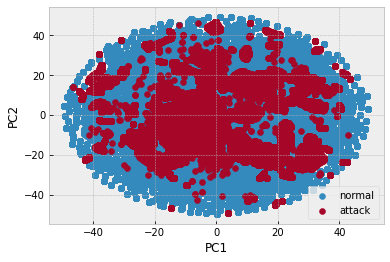

In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr, df_te = df_tr.sample(frac=1).reset_index(drop=True), df_te.sample(frac=1).reset_index(drop=True)
df_tr_drop, df_te_drop = df_tr.drop(drop_cols, axis = 1), df_te.drop(drop_cols, axis = 1)

# separate the data from the labels for the training and testing data 
Xtr, Xte = df_tr_drop.values[:,:-1], df_te_drop.values[:,:-1]
ytr, yte = df_tr_drop['label'].values, df_te_drop['label'].values

# standardize the data based on the transform found from the training data 
scaler = preprocessing.StandardScaler().fit(Xtr)
Xtr, Xte = scaler.transform(Xtr), scaler.transform(Xte)

X_embedded = TSNE(n_components=2).fit_transform(Xtr)

# plot out the PCA projections on the training and testing data 
plt.figure()
plt.scatter(X_embedded[ytr==1,0], X_embedded[ytr==1,1], label='normal')
plt.scatter(X_embedded[ytr==0,0], X_embedded[ytr==0,1], label='attack')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.savefig(output_path + 'tsne_tr.pdf')


## Mutual Information Ranks and Stability 


egin{enumerate}
  \item dsport: Destination port number
  \item dur: Record total duration
  \item proto: Transaction protocol
  \item sbytes: Source to destination transaction bytes 
  \item Stime: record start time
  \item state: Indicates to the state and its dependent protocol, e.g. ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR, REQ, RST, TST, TXD, URH, URN, and (-) (if not used state)
  \item dbytes: Destination to source transaction bytes
  \item srcip: Source IP address
  \item dmeansz: Mean of the ?ow packet size transmitted by the dst 
  \item trans_depth: Represents the pipelined depth into the connection of http request/response transaction
\end{enumerate}


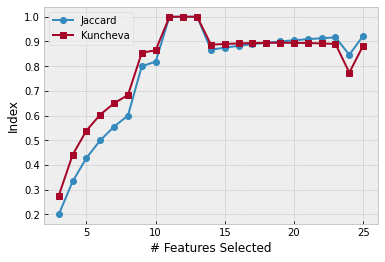

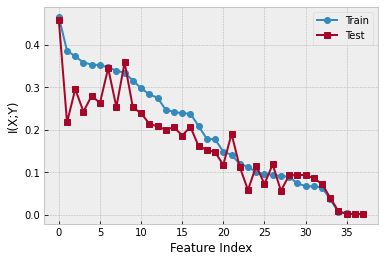

In [ ]:
n_avg = 10

# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')
feature_names = pd.read_csv(data_path + 'NUSW-NB15_features.csv')['Name'].values
feature_descr = pd.read_csv(data_path + 'NUSW-NB15_features.csv')['Description'].values

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})
df_te = df_te.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

Xtr, Xte, ytr, yte = df_tr.values[:,:-1], df_te.values[:,:-1], df_tr.values[:,-1], df_te.values[:,-1]

mitr, mite = mutual_info_classif(Xtr, ytr), mutual_info_classif(Xte, yte)
sort_mitr, sort_mite = np.argsort(mitr)[::-1], np.argsort(mite)[::-1]

k_max = 25
K = Xtr.shape[1]

jacs, kunc, x = [], [], []
for k in range(3, k_max+1):
  x.append(k)
  jacs.append(jaccard(sort_mitr[:k], sort_mite[:k]))
  kunc.append(kuncheva(sort_mitr[:k], sort_mite[:k], K))

plt.figure()
plt.plot(x, jacs, marker='o', label='Jaccard')
plt.plot(x, kunc, marker='s', label='Kuncheva')
plt.xlabel('# Features Selected')
plt.ylabel('Index')
plt.legend()
plt.savefig(output_path + 'feature_stabilities.pdf')


plt.figure()
plt.plot(mitr[sort_mitr], marker='o', label='Train')
plt.plot(mite[sort_mitr], marker='s', label='Test')
plt.xlabel('Feature Index')
plt.ylabel('I(X;Y)')
plt.legend()
plt.savefig(output_path + 'feature_ranks.pdf')

# print out the top 10 features in a latex list
print('\begin{enumerate}')
for i in sort_mitr[:10]:
  print('  \item ' + feature_names[i] + ': ' + feature_descr[i]) 
print('\end{enumerate}')

## JMI Plots 

Running JMI


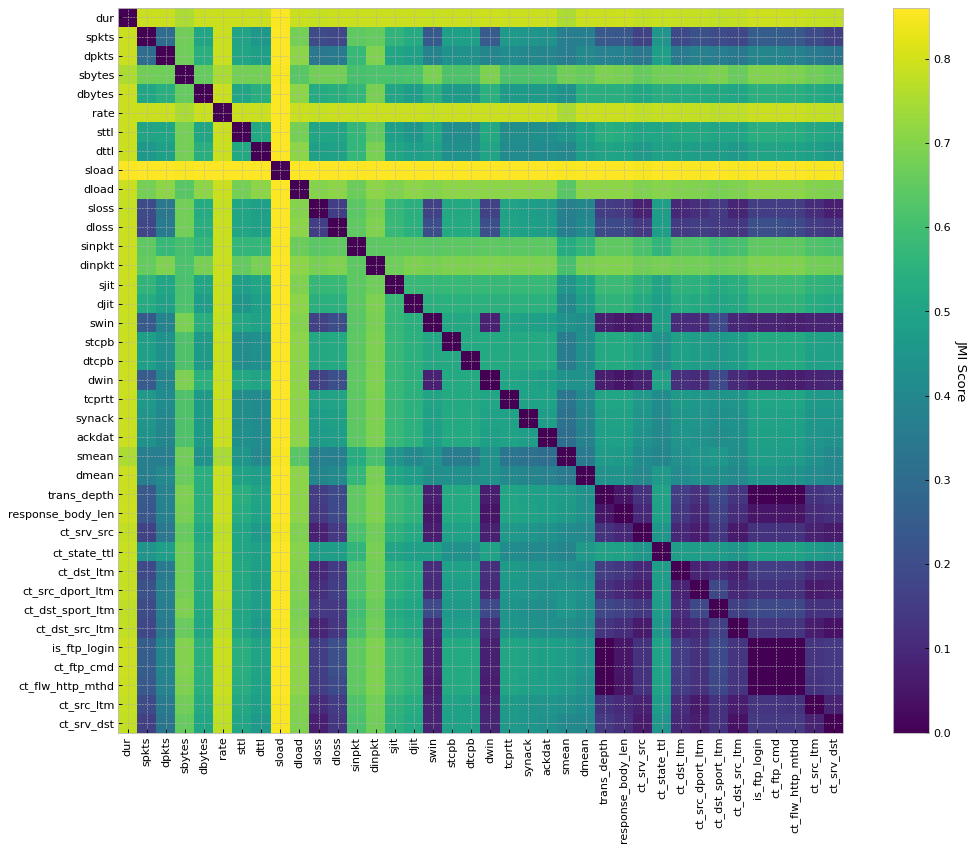

In [50]:
# drop_cols = ['id', 'proto', 'service', 'state', 'attack_cat', 'is_sm_ips_ports']

# read in the csv files saved in the google drive 
df_tr = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv')


# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True)
df_tr_drop = df_tr.drop(drop_cols, axis = 1)

# separate the data from the labels for the training and testing data 
Xtr = df_tr_drop.values[:,:-1]
ytr = df_tr_drop['label'].values

# standardize the data based on the transform found from the training data 
scaler = preprocessing.StandardScaler().fit(Xtr)
Xtr = scaler.transform(Xtr) 
n, K = Xtr.shape
feat_names = df_tr_drop.drop('label', axis = 1).keys()

J = np.zeros((K, K))

# fill in the off diagonals
print('Running JMI')
for i in range(K): 
    for j in range(K): 
      if j > i: 
          _, jcmi, mify = LCSI.lcsi(Xtr[:,[i,j]], ytr, function_name='JMI', n_selected_features=2)
          J[i,j], J[j,i] = mify[0] - jcmi[1]/2, mify[0] - jcmi[1]/2


fig, ax = plt.subplots(figsize=(16, 12), dpi=80)
im = ax.imshow(J)


cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel('JMI Score', rotation=-90, va="bottom")
    
    
# We want to show all ticks...
ax.set_xticks(np.arange(len(feat_names)))
ax.set_yticks(np.arange(len(feat_names)))
# ... and label them with the respective list entries
ax.set_xticklabels(feat_names, rotation=90)
ax.set_yticklabels(feat_names)

plt.savefig(code_path+'outputs/jmis.pdf', bbox_inches='tight')


# Binary Classification Experiments



## Evaluate Prequential

In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).rename(columns={"label": "target"}).drop(drop_cols, axis = 1)
df_te = df_te.sample(frac=1).reset_index(drop=True).rename(columns={"label": "target"}).drop(drop_cols, axis = 1)

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

N1 = len(df_tr)

# instantiate a based classifier from each of the classifiers in multiflow that 
# we are going to benchmark against. 
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier(), w=poisson_parameter)
         ]
N = len(clfrs)


# concat the training and testing data into a stream 
df = pd.concat([df_tr, df_te])
stream = DataStream(df)

mdls = []
evals = []

for n in range(N): 
  print('Running... ' + output_files[n])
  mdl = clfrs[n]   # get the classifier 
  # configure the prequential datastream evaluator. results are saved to the 
  # google drive. 
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + output_files[n] + '.csv')
  # process the datastream then save off the models and evaluation 
  mdl = eval.evaluate(stream=stream, model=mdl)
  mdls.append(mdl[0])
  evals.append(eval)
  print(' ')

# write the output to a pickle file 
data = {'mdls': mdls, 'evals': evals}
pkl.dump(data, open(output_path + 'prequential_models_evaluators.pkl', 'wb'))


Running... output_ht_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [121.55s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.9210
M0 - Kappa        : 0.8254
M0 - F1 score: 0.9396
M0 - Training time (s)  : 83.91
M0 - Testing time  (s)  : 26.05
M0 - Total time    (s)  : 109.96
M0 - Size (kB)          : 4162.4297
 
Running... output_bag_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [1377.95s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.9291
M0 - Kappa        : 0.8428
M0 - F1 score: 0.9460
M0 - Training time (s)  : 963.30
M0 - Testing time  (s)  : 290.14
M0 - Total time    (s)  : 1253.44
M0 - Size (kB)          : 41038.6445
 
Running... output_bagwin_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [1621.60s]
Processed samp

In [ ]:
# the results from the prequential experiements need to be loaded from the drive 
# since they are not in the environment
df_ht = pd.read_csv(output_path + 'output_ht_m.csv', comment='#')
df_bag = pd.read_csv(output_path + 'output_bag_m.csv', comment='#')
df_bagwin = pd.read_csv(output_path + 'output_bagwin_m.csv', comment='#')
df_leverage = pd.read_csv(output_path + 'output_leverage_m.csv', comment='#')

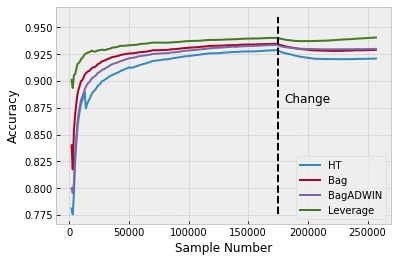

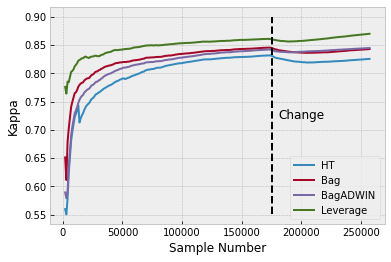

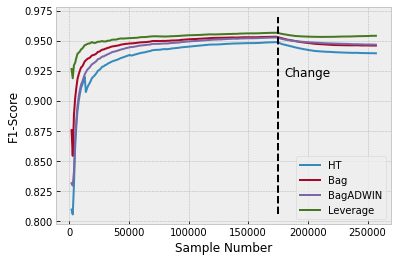

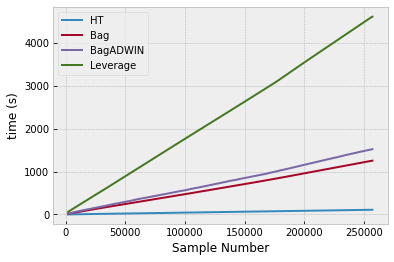

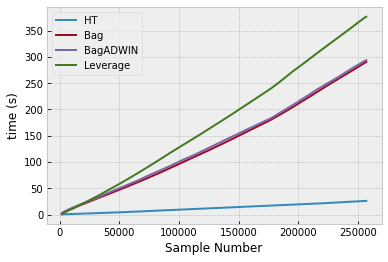

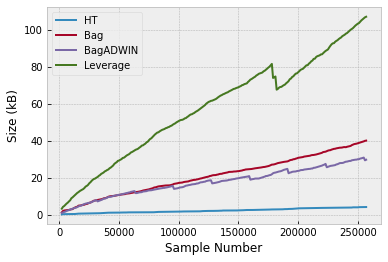

In [ ]:
# plot the accuracies 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_acc_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['mean_acc_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_acc_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_acc_[M0]'], label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_acc_[M0]']), 0.96], color='k', linestyle='--')
plt.text(N1+5000, .88, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Accuracy')
plt.savefig(output_path + 'online_accuracy_m.pdf')

# plot the kappa statistics 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_kappa_[M0]'],label='HT')
plt.plot(df_bag['id'], df_bag['mean_kappa_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_kappa_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_kappa_[M0]'], label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_kappa_[M0]']), 0.9], color='k', linestyle='--')
plt.text(N1+5000, .72, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Kappa')
plt.savefig(output_path + 'online_kappa_m.pdf')

# plot the f1-scores 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_f1_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['mean_f1_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_f1_[M0]'],label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_f1_[M0]'], label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_f1_[M0]']), 0.97], color='k', linestyle='--')
plt.text(N1+5000, .92, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('F1-Score')
plt.savefig(output_path + 'online_f1_m.pdf')



# plot the total_running_time_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['total_running_time_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['total_running_time_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['total_running_time_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['total_running_time_[M0]'], label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'online_time_m.pdf')

# plot the testing_time_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['testing_time_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['testing_time_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['testing_time_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['testing_time_[M0]'],  label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'online_test_time_m.pdf')


# plot the model_size_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['model_size_[M0]']/1024, label='HT')
plt.plot(df_bag['id'], df_bag['model_size_[M0]']/1024,  label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['model_size_[M0]']/1024,  label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['model_size_[M0]']/1024,  label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Size (kB)')
plt.savefig(output_path + 'online_size_m.pdf')

In [ ]:
# print out the latex tables 
print('\\bf Metric & \\bf HT & \\bf Bagging & \\bf BagADWIN & \\bf Leverage \\\\')
print('\\hline\\hline')
print('Accuracy & ', 
      str(100*df_ht['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_acc_[M0]'].values[-1]) + ' \\\\ '
      )
print('$\kappa$ & ', 
      str(100*df_ht['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_kappa_[M0]'].values[-1]) + ' \\\\ '
      )
print('F1-Score & ', 
      str(100*df_ht['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_f1_[M0]'].values[-1]) + ' \\\\ '
      )

\bf Metric & \bf HT & \bf Bagging & \bf BagADWIN & \bf Leverage \\
\hline\hline
Accuracy &  92.0969 &  92.90700000000001 &  92.99770000000001 &  94.06040000000002 \\ 
$\kappa$ &  82.542 &  84.2835 &  84.47059999999999 &  86.98469999999999 \\ 
F1-Score &  93.9636 &  94.60270000000001 &  94.67770000000002 &  95.417 \\ 


## Evaluate Holdout

In [ ]:
# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})
df_te = df_te.sample(frac=1).reset_index(drop=True).drop(drop_cols, axis = 1).rename(columns={"label": "target"})

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

# set the data stream for learning. we are only going to use the training stream 
# to build the model; however, unlike the previous experiement we do not care 
# about the output result stream. rather we want the hold out performance 
stream = DataStream(df_tr)

X_train = df_tr.values[:,:-1]
y_train = df_tr['target'].values
X_hold = df_te.values[:,:-1]
y_hold = df_te['target'].values

# instantiate a based classifier from each of the classifiers in multiflow that 
# we are going to benchmark against. 
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier(), w=poisson_parameter)
         ]
N = len(clfrs)
clfrs_names = ['HT', 'Bag', 'BagADWIN', 'Leverage']

N = len(clfrs)
accs, f1s, kappas = [], [], []

for n in range(N): 
  print(clfrs_names[n])

  # learn the model on the training data stream that is defined by the training 
  # data. this is specified by the original authors 
  mdl = clfrs[n]
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + 'tmp.csv')
  mdl = eval.evaluate(stream=stream, model=mdl)

  # get the predictions on the hold out dataset then calculate the accuracy, 
  # f1-score and kappa statistics. 
  y_hat = mdl[0].predict(X_hold)
  acc, f1, kappa = calc_metrics(y_hold, y_hat)
  accs.append(acc)
  f1s.append(f1)
  kappas.append(kappa)
  print(' ')

# remove the temporary data file that was used to save the prequential results 
# of the online models. all the algorithms write the same tmp.csv file. 
os.remove(output_path + 'tmp.csv')

# write the classification statistics to a python file  
data = {'accs': accs, 'f1s': f1s, 'kappas': kappas, 'clfr_names': clfrs_names}
pkl.dump(data, open(output_path + 'holdout_classifcation_statistics.pkl', 'wb'))

# evaluate the static classifiers on the train/test hold out experiment
static_clfr_name = [
                    'CART (static)',
                    'Bagging (static)'
                    ]
static_clfr = [DecisionTreeClassifier(), BaggingClassifier()]
accs_static, f1s_static, kappas_static = [], [], []

for n in range(len(static_clfr)):
  print(static_clfr_name[n])
  y_hat = static_clfr[n].fit(X_train, y_train).predict(X_hold)
  acc, f1, kappa = calc_metrics(y_hold, y_hat)
  accs_static.append(acc)
  f1s_static.append(f1)
  kappas_static.append(kappa)


HT
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [76.67s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.9310
M0 - Kappa        : 0.8375
M0 - F1 score: 0.9504
M0 - Training time (s)  : 54.78
M0 - Testing time  (s)  : 16.63
M0 - Total time    (s)  : 71.41
M0 - Size (kB)          : 2504.6172
 
Bag
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [925.16s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.9334
M0 - Kappa        : 0.8419
M0 - F1 score: 0.9524
M0 - Training time (s)  : 672.72
M0 - Testing time  (s)  : 189.44
M0 - Total time    (s)  : 862.16
M0 - Size (kB)          : 27591.1484
 
BagADWIN
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [1026.47s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.9331
M0 - 

In [ ]:
# print out the latex tables  
' & '.join(clfrs_names) + '\\\\'
for n in range(N): 
  print(clfrs_names[n] + ' & ' + str(100*accs[n])+ ' & ' + str(100*f1s[n])+ ' & ' + str(100*kappas[n]) + '\\\\')

for n in range(len(static_clfr)): 
  print(static_clfr_name[n] + ' & ' + str(100*accs_static[n])+ ' & ' + str(100*f1s_static[n])+ ' & ' + str(100*kappas_static[n]) + '\\\\')


## Lambda Experiment 

In [ ]:
LAMBDA = [1., 2., 5., 7., 10.]
  

# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).rename(columns={"label": "target"}).drop(drop_cols, axis = 1)
df_te = df_te.sample(frac=1).reset_index(drop=True).rename(columns={"label": "target"}).drop(drop_cols, axis = 1)

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

N1 = len(df_tr)


# concat the training and testing data into a stream 
df = pd.concat([df_tr, df_te])
stream = DataStream(df)

mdls = []
evals = []

for n in range(len(LAMBDA)): 
  print('Running... Lambda = ' + str(LAMBDA[n]))
  mdl = LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier(), w=LAMBDA[n])
  # configure the prequential datastream evaluator. results are saved to the 
  # google drive. 
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + 'lambda_' + str(int(LAMBDA[n])) + '.csv')
  # process the datastream then save off the models and evaluation 
  mdl = eval.evaluate(stream=stream, model=mdl)
  mdls.append(mdl[0])
  evals.append(eval)
  print(' ')

# write the output to a pickle file 
data = {'mdls': mdls, 'evals': evals}
pkl.dump(data, open(output_path + 'prequential_models_evaluators_lambda.pkl', 'wb'))


Running... Lambda = 1.0
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [2204.52s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.9284
M0 - Kappa        : 0.8409
M0 - F1 score: 0.9457
M0 - Training time (s)  : 1766.64
M0 - Testing time  (s)  : 318.87
M0 - Total time    (s)  : 2085.51
M0 - Size (kB)          : 36671.0693
 
Running... Lambda = 2.0
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [3283.05s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.9361
M0 - Kappa        : 0.8595
M0 - F1 score: 0.9510
M0 - Training time (s)  : 2738.55
M0 - Testing time  (s)  : 347.02
M0 - Total time    (s)  : 3085.57
M0 - Size (kB)          : 59605.5967
 
Running... Lambda = 5.0
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [5752.88s]
Processed

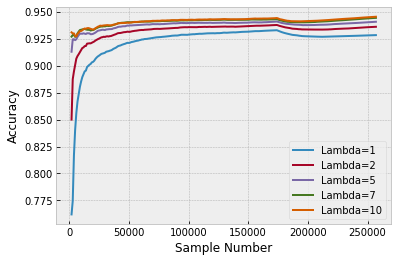

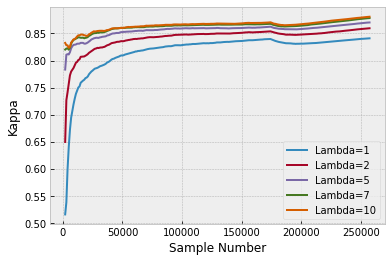

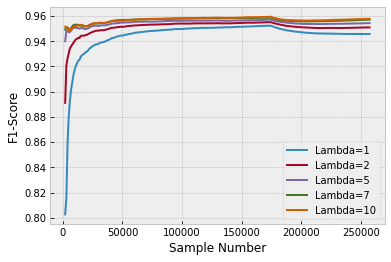

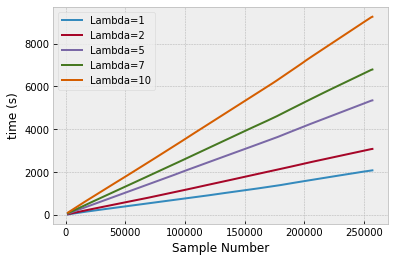

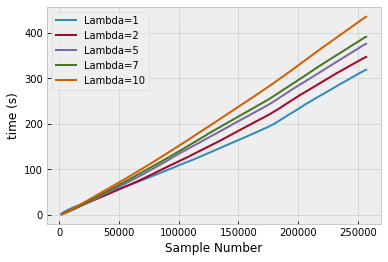

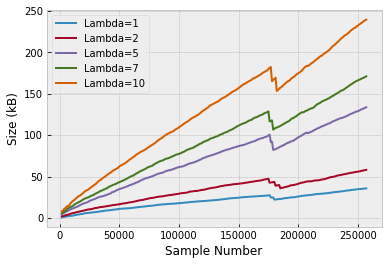

In [ ]:
# the results from the prequential experiements need to be loaded from the drive 
# since they are not in the environment
df_l1 = pd.read_csv(output_path + 'lambda_1.csv', comment='#')
df_l2 = pd.read_csv(output_path + 'lambda_2.csv', comment='#')
df_l5 = pd.read_csv(output_path + 'lambda_5.csv', comment='#')
df_l7 = pd.read_csv(output_path + 'lambda_7.csv', comment='#')
df_l10 = pd.read_csv(output_path + 'lambda_10.csv', comment='#')


# plot the accuracies 
plt.figure()
plt.plot(df_l1['id'], df_l1['mean_acc_[M0]'], label='Lambda=1')
plt.plot(df_l2['id'], df_l2['mean_acc_[M0]'], label='Lambda=2')
plt.plot(df_l5['id'], df_l5['mean_acc_[M0]'], label='Lambda=5')
plt.plot(df_l7['id'], df_l7['mean_acc_[M0]'], label='Lambda=7')
plt.plot(df_l10['id'], df_l10['mean_acc_[M0]'], label='Lambda=10')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Accuracy')
plt.savefig(output_path + 'lambda_accuracy_m.pdf')

# plot the kappa statistics 
plt.figure()
plt.plot(df_l1['id'], df_l1['mean_kappa_[M0]'], label='Lambda=1')
plt.plot(df_l2['id'], df_l2['mean_kappa_[M0]'], label='Lambda=2')
plt.plot(df_l5['id'], df_l5['mean_kappa_[M0]'], label='Lambda=5')
plt.plot(df_l7['id'], df_l7['mean_kappa_[M0]'], label='Lambda=7')
plt.plot(df_l10['id'], df_l10['mean_kappa_[M0]'], label='Lambda=10')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Kappa')
plt.savefig(output_path + 'lambda_kappa_m.pdf')

# plot the f1-scores 
plt.figure()
plt.plot(df_l1['id'], df_l1['mean_f1_[M0]'], label='Lambda=1')
plt.plot(df_l2['id'], df_l2['mean_f1_[M0]'], label='Lambda=2')
plt.plot(df_l5['id'], df_l5['mean_f1_[M0]'], label='Lambda=5')
plt.plot(df_l7['id'], df_l7['mean_f1_[M0]'], label='Lambda=7')
plt.plot(df_l10['id'], df_l10['mean_f1_[M0]'], label='Lambda=10')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('F1-Score')
plt.savefig(output_path + 'lambda_f1_m.pdf')


# plot the total_running_time_ 
plt.figure()
plt.plot(df_l1['id'], df_l1['total_running_time_[M0]'], label='Lambda=1')
plt.plot(df_l2['id'], df_l2['total_running_time_[M0]'], label='Lambda=2')
plt.plot(df_l5['id'], df_l5['total_running_time_[M0]'], label='Lambda=5')
plt.plot(df_l7['id'], df_l7['total_running_time_[M0]'], label='Lambda=7')
plt.plot(df_l10['id'], df_l10['total_running_time_[M0]'], label='Lambda=10')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'lambda_time_m.pdf')

# plot the testing_time_ 
plt.figure()
plt.plot(df_l1['id'], df_l1['testing_time_[M0]'], label='Lambda=1')
plt.plot(df_l2['id'], df_l2['testing_time_[M0]'], label='Lambda=2')
plt.plot(df_l5['id'], df_l5['testing_time_[M0]'], label='Lambda=5')
plt.plot(df_l7['id'], df_l7['testing_time_[M0]'], label='Lambda=7')
plt.plot(df_l10['id'], df_l10['testing_time_[M0]'], label='Lambda=10')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'lambda_test_time_m.pdf')


# plot the model_size_ 
plt.figure()
plt.plot(df_l1['id'], df_l1['model_size_[M0]']/1024, label='Lambda=1')
plt.plot(df_l2['id'], df_l2['model_size_[M0]']/1024, label='Lambda=2')
plt.plot(df_l5['id'], df_l5['model_size_[M0]']/1024, label='Lambda=5')
plt.plot(df_l7['id'], df_l7['model_size_[M0]']/1024, label='Lambda=7')
plt.plot(df_l10['id'], df_l10['model_size_[M0]']/1024, label='Lambda=10')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Size (kB)')
plt.savefig(output_path + 'lambda_size_m.pdf')


# Multiclass Experiments [Subpar performances]




## Evaluate Prequential 

In [ ]:
# need a different drop cols
drop_cols = ['id', 'proto', 'service', 'state', 'label', 'is_sm_ips_ports']

# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).rename(columns={"attack_cat": "target"}).drop(drop_cols, axis = 1)
df_te = df_te.sample(frac=1).reset_index(drop=True).rename(columns={"attack_cat": "target"}).drop(drop_cols, axis = 1)

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

#df_tr['target'] = df_tr['target'].astype(str) 
#df_te['target'] = df_te['target'].astype(str) 
classes = list(np.unique(df_tr['target']))
df_tr['target'] = df_tr['target'].apply(classes.index)
df_te['target'] = df_te['target'].apply(classes.index)

N1 = len(df_tr)

# reset the base classifiers for the learning model and setup the base clfr 
# names for the latex tables 
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier())
         ]
clfrs_names = ['HT', 'Bag', 'BagADWIN', 'Leverage']
N = len(clfrs)


# concat the training and testing data into a stream 
df = pd.concat([df_tr, df_te])
stream = DataStream(df)

mdls = []
evals = []

for n in range(N): 
  print('Running... ' + output_files[n])
  mdl = clfrs[n]   # get the classifier 
  # configure the prequential datastream evaluator. results are saved to the 
  # google drive. 
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + output_files[n] + '_mc.csv')
  # process the datastream then save off the models and evaluation 
  mdl = eval.evaluate(stream=stream, model=mdl)
  mdls.append(mdl[0])
  evals.append(eval)
  print(' ')

# write the output to a pickle file 
data = {'mdls': mdls, 'evals': evals}
pkl.dump(data, open(output_path + 'prequential_models_evaluators_mc.pkl', 'wb'))


Running... output_ht_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [327.90s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.6591
M0 - Kappa        : 0.5583
M0 - F1 score: 0.3128
M0 - Training time (s)  : 244.01
M0 - Testing time  (s)  : 74.96
M0 - Total time    (s)  : 318.97
M0 - Size (kB)          : 2128.5469
 
Running... output_bag_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [3710.39s]
Processed samples: 258000
Mean performance:
M0 - Accuracy     : 0.6763
M0 - Kappa        : 0.5830
M0 - F1 score: 0.3453
M0 - Training time (s)  : 2784.60
M0 - Testing time  (s)  : 851.34
M0 - Total time    (s)  : 3635.94
M0 - Size (kB)          : 18420.0977
 
Running... output_bagwin_m
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [4365.60s]
Processed sa

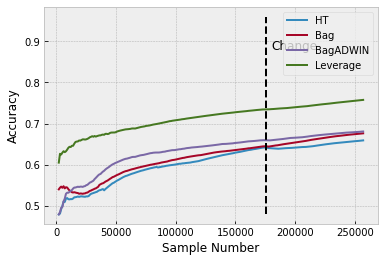

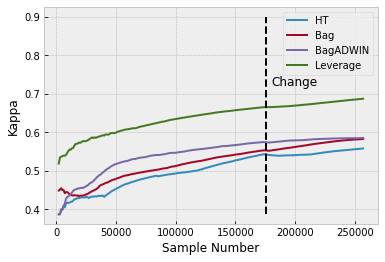

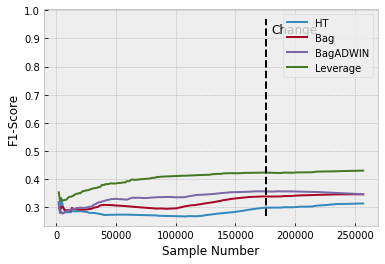

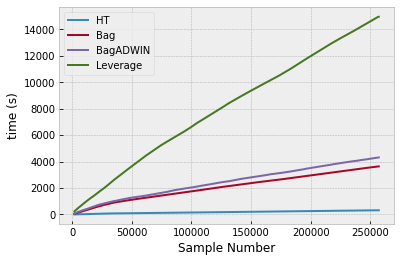

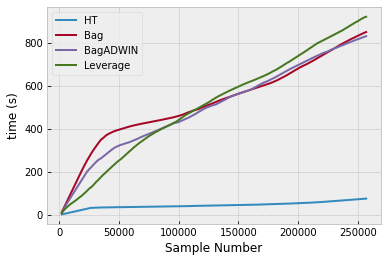

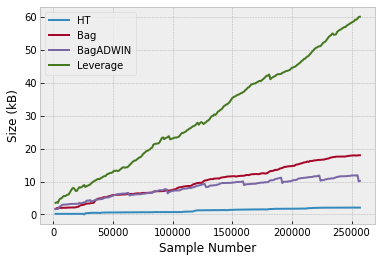

In [ ]:
# the results from the prequential experiements need to be loaded from the drive 
# since they are not in the environment
df_ht = pd.read_csv(output_path + 'output_ht_m_mc.csv', comment='#')
df_bag = pd.read_csv(output_path + 'output_bag_m_mc.csv', comment='#')
df_bagwin = pd.read_csv(output_path + 'output_bagwin_m_mc.csv', comment='#')
df_leverage = pd.read_csv(output_path + 'output_leverage_m_mc.csv', comment='#')


# plot the accuracies 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_acc_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['mean_acc_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_acc_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_acc_[M0]'], label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_acc_[M0]']), 0.96], color='k', linestyle='--')
plt.text(N1+5000, .88, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Accuracy')
plt.savefig(output_path + 'online_accuracy_m_mc.pdf')

# plot the kappa statistics 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_kappa_[M0]'],label='HT')
plt.plot(df_bag['id'], df_bag['mean_kappa_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_kappa_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_kappa_[M0]'], label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_kappa_[M0]']), 0.9], color='k', linestyle='--')
plt.text(N1+5000, .72, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Kappa')
plt.savefig(output_path + 'online_kappa_m_mc.pdf')

# plot the f1-scores 
plt.figure()
plt.plot(df_ht['id'], df_ht['mean_f1_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['mean_f1_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['mean_f1_[M0]'],label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['mean_f1_[M0]'], label='Leverage')
plt.plot([N1,N1], [np.min(df_ht['mean_f1_[M0]']), 0.97], color='k', linestyle='--')
plt.text(N1+5000, .92, 'Change', fontsize=12)
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('F1-Score')
plt.savefig(output_path + 'online_f1_m_mc.pdf')



# plot the total_running_time_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['total_running_time_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['total_running_time_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['total_running_time_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['total_running_time_[M0]'], label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'online_time_m_mc.pdf')

# plot the testing_time_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['testing_time_[M0]'], label='HT')
plt.plot(df_bag['id'], df_bag['testing_time_[M0]'], label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['testing_time_[M0]'], label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['testing_time_[M0]'],  label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('time (s)')
plt.savefig(output_path + 'online_test_time_m_mc.pdf')


# plot the model_size_ 
plt.figure()
plt.plot(df_ht['id'], df_ht['model_size_[M0]']/1024, label='HT')
plt.plot(df_bag['id'], df_bag['model_size_[M0]']/1024,  label='Bag')
plt.plot(df_bagwin['id'], df_bagwin['model_size_[M0]']/1024,  label='BagADWIN')
plt.plot(df_leverage['id'], df_leverage['model_size_[M0]']/1024,  label='Leverage')
plt.legend()
plt.xlabel('Sample Number')
plt.ylabel('Size (kB)')
plt.savefig(output_path + 'online_size_m_mc.pdf')

In [ ]:
# print out the latex tables 
print('\\bf Metric & \\bf HT & \\bf Bagging & \\bf BagADWIN & \\bf Leverage \\\\')
print('\\hline\\hline')
print('Accuracy & ', 
      str(100*df_ht['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_acc_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_acc_[M0]'].values[-1]) + ' \\\\ '
      )
print('$\kappa$ & ', 
      str(100*df_ht['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_kappa_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_kappa_[M0]'].values[-1]) + ' \\\\ '
      )
print('F1-Score & ', 
      str(100*df_ht['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_bag['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_bagwin['mean_f1_[M0]'].values[-1]) + ' & ',
      str(100*df_leverage['mean_f1_[M0]'].values[-1]) + ' \\\\ '
      )

\bf Metric & \bf HT & \bf Bagging & \bf BagADWIN & \bf Leverage \\
\hline\hline
Accuracy &  65.9104 &  67.62939999999999 &  68.07560000000001 &  75.7663 \\ 
$\kappa$ &  55.8334 &  58.2971 &  58.55819999999999 &  68.7321 \\ 
F1-Score &  31.279600000000002 &  34.5295 &  34.56 &  42.954100000000004 \\ 


## Evaluate Holdout

In [ ]:
# need a different drop cols
drop_cols = ['id', 'proto', 'service', 'state', 'label', 'is_sm_ips_ports']

# read in the csv files saved in the google drive 
df_tr, df_te = pd.read_csv(data_path + 'UNSW_NB15_training-set.csv'), pd.read_csv(data_path + 'UNSW_NB15_testing-set.csv')

# 1) randomly shuffle rows; 2) rename label column; 3) drop not useful columns 
df_tr = df_tr.sample(frac=1).reset_index(drop=True).rename(columns={"attack_cat": "target"}).drop(drop_cols, axis = 1)
df_te = df_te.sample(frac=1).reset_index(drop=True).rename(columns={"attack_cat": "target"}).drop(drop_cols, axis = 1)

# standardize the training and testing data stream. use the mean/std of the 
# training data to standarized the testing data (i.e., only use information 
# available at training time). 
df_tr, df_te = standardize_df_off_tr(df_tr, df_te)

classes = list(np.unique(df_tr['target']))
df_tr['target'] = df_tr['target'].apply(classes.index)
df_te['target'] = df_te['target'].apply(classes.index)

# instantiate a based classifier from each of the classifiers in multiflow that 
# we are going to benchmark against. 
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier(), w=poisson_parameter)
         ]
N = len(clfrs)

# set the data stream for learning. we are only going to use the training stream 
# to build the model; however, unlike the previous experiement we do not care 
# about the output result stream. rather we want the hold out performance 
stream = DataStream(df_tr)

X_train = df_tr.values[:,:-1]
y_train = df_tr['target'].values
X_hold = df_te.values[:,:-1]
y_hold = df_te['target'].values

# reset the base classifiers for the learning model and setup the base clfr 
# names for the latex tables 
clfrs = [
         HoeffdingTreeClassifier(), 
         OzaBaggingClassifier(base_estimator=HoeffdingTreeClassifier()),
         OzaBaggingADWINClassifier(base_estimator=HoeffdingTreeClassifier()),
         LeveragingBaggingClassifier(base_estimator=HoeffdingTreeClassifier())
         ]
clfrs_names = ['HT', 'Bag', 'BagADWIN', 'Leverage']

N = len(clfrs)
accs, f1s, kappas = [], [], []

for n in range(N): 
  print(clfrs_names[n])

  # learn the model on the training data stream that is defined by the training 
  # data. this is specified by the original authors 
  mdl = clfrs[n]
  eval = EvaluatePrequential(show_plot=False, 
                             pretrain_size=pretrain_size, 
                             batch_size=batch_size, 
                             metrics=metrics, 
                             max_samples=max_samples,
                             output_file=output_path + 'tmp.csv')
  mdl = eval.evaluate(stream=stream, model=mdl)

  # get the predictions on the hold out dataset then calculate the accuracy, 
  # f1-score and kappa statistics. 
  y_hat = mdl[0].predict(X_hold)

  # TODO - GENERATE CONFUSION MATRIX
  
  acc, f1, kappa = calc_metrics(y_hold, y_hat)
  accs.append(acc)
  f1s.append(f1)
  kappas.append(kappa)
  print(' ')

# remove the temporary data file that was used to save the prequential results 
# of the online models. all the algorithms write the same tmp.csv file. 
os.remove(output_path + 'tmp.csv')

# write the classification statistics to a python file  
data = {'accs': accs, 'f1s': f1s, 'kappas': kappas, 'clfr_names': clfrs_names}
pkl.dump(data, open(output_path + 'holdout_classifcation_statistics_mc.pkl', 'wb'))

# evaluate the static classifiers on the train/test hold out experiment
static_clfr_name = [
                    'CART (static)',
                    'Bagging (static)'
                    ]
static_clfr = [DecisionTreeClassifier(), BaggingClassifier()]
accs_static, f1s_static, kappas_static = [], [], []

for n in range(len(static_clfr)):
  print(static_clfr_name[n])
  y_hat = static_clfr[n].fit(X_train, y_train).predict(X_hold)
  acc, f1, kappa = calc_metrics(y_hold, y_hat)
  accs_static.append(acc)
  f1s_static.append(f1)
  kappas_static.append(kappa)


HT
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [254.95s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.6301
M0 - Kappa        : 0.5356
M0 - F1 score: 0.3207
M0 - Training time (s)  : 181.55
M0 - Testing time  (s)  : 69.75
M0 - Total time    (s)  : 251.31
M0 - Size (kB)          : 1236.2812
 
Bag
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [2577.54s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.6458
M0 - Kappa        : 0.5564
M0 - F1 score: 0.3409
M0 - Training time (s)  : 1938.12
M0 - Testing time  (s)  : 606.23
M0 - Total time    (s)  : 2544.35
M0 - Size (kB)          : 11868.4023
 
BagADWIN
Prequential Evaluation
Evaluating 1 target(s).
Pre-training on 2000 sample(s).
Evaluating...
 #################### [100%] [3312.01s]
Processed samples: 176000
Mean performance:
M0 - Accuracy     : 0.6472

In [ ]:
# print out the latex tables  
' & '.join(clfrs_names) + '\\\\'
for n in range(N): 
  print(clfrs_names[n] + ' & ' + str(100*accs[n])+ ' & ' + str(100*f1s[n])+ ' & ' + str(100*kappas[n]) + '\\\\')

for n in range(len(static_clfr)): 
  print(static_clfr_name[n] + ' & ' + str(100*accs_static[n])+ ' & ' + str(100*f1s_static[n])+ ' & ' + str(100*kappas_static[n]) + '\\\\')


HT & 56.17792421746294 & 52.66903914590747 & 15.756905385522444\\
Bag & 50.70422535211267 & 5.405405405405405 & 0.08041817450743097\\
BagADWIN & 48.433734939759034 & 2.727272727272727 & -2.8989201464522507\\
Leverage & 53.73134328358209 & 6.0606060606060606 & 0.47915668423575175\\
CART (static) & 44.26229508196721 & 50.36496350364964 & -13.178717598908591\\
Bagging (static) & 44.32234432234432 & 15.555555555555555 & -2.1364576154376294\\
